# Space Invader with Policy Gradient

## Step 1: Import the libraries

In [1]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('SpaceInvaders-v0')
env.seed(1)
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment
Execute the code cell below to play Space Invader with a random policy.

The size of frame is:  (210, 160, 3)
No. of Actions:  6


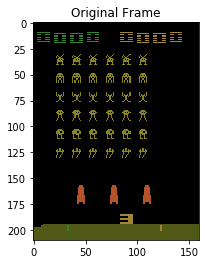

In [3]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

In [4]:
def random_play():
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        if done:
            env.close()
            break
random_play()

## Step 4:Preprocessing Frame

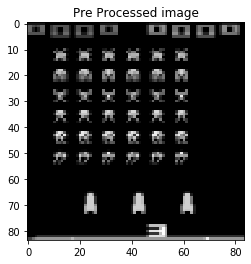

In [5]:
def preprocess_frame(screen):
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[8:-12, 4:-12]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (84, 84), interpolation = cv2.INTER_AREA)
    return screen

env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset()), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [6]:
def stack_frame(stacked_frames, state, is_new=False):
    frame = preprocess_frame(state)
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

## Step 6: Creating Replay Memory

In [7]:
def discount_and_normalize_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * GAMMA + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)

    return discounted_episode_rewards

## Step 7: Creating Deep Learning Model

In [8]:
class Network(nn.Module):
    def __init__(self, num_actions=6):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return F.softmax(self.fc5(x), dim=1)

## Step 8: Creating out agent

In [9]:
GAMMA = .95            # discount factor
LR = 0.002              # learning rate 

class Agent():
    def __init__(self, action_size):
        self.action_size = action_size
        
        # Q-Network
        self.policy_net = Network(action_size).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        
        self.saved_log_probs = []
        self.rewards = []
        
    
    def step(self, reward, log_probs):
        # Save rewards and log_probs
        self.rewards.append(reward)
        self.saved_log_probs.append(log_probs)
        
                
    def act(self, state):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.policy_net(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
        
    def reset(self):
        self.saved_log_probs = []
        self.rewards = []
        
    def learn(self, gamma):
        R = torch.from_numpy(discount_and_normalize_rewards(self.rewards))
        
        policy_loss = []
        for log_prob in self.saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

## Step 9: Watching untrained agent play

In [10]:
agent = Agent(action_size= env.action_space.n)

# watch an untrained agent
state = stack_frame(None, env.reset(), True) 
for j in range(200):
    env.render()
    action, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frame(state, next_state, False)
    if done:
        break 
        
env.close()

## Step 10: Loading Agent
Uncomment line to load a pretrained agent

In [11]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=100)

# To Load checkpoint uncomment code
# checkpoint = torch.load('space_invader_dqn.pth')
# agent.policy_net.load_state_dict(checkpoint['state_dict'])
# agent.target_net.load_state_dict(checkpoint['state_dict'])
# agent.optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# scores = checkpoint['socres']

# index = 1
# for i in reversed(scores):
#     scores_window.append(i)
#     if index == 100:
#         break
#     index += 1

## Step 11: Train the Agent with DQN

In [12]:
def train(n_episodes=2000):
    for i_episode in range(start_epoch+1, n_episodes+1):
        state = stack_frame(None, env.reset(), True)
        agent.reset()
        score = 0
        while True:
            action, log_probs = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = stack_frame(state, next_state, False)
            score += reward
            reward = -100 if done else reward  
            agent.step(reward, log_probs)
            if done:
                break
        agent.learn(GAMMA)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            state = {'epoch': i_episode,'state_dict': agent.policy_net.state_dict(),'optimizer': agent.optimizer.state_dict(),
                     'socres': scores }
            torch.save(state, "space_invader_{}.pth".format(i_episode))
    
    return scores

Episode 100	Average Score: 151.20


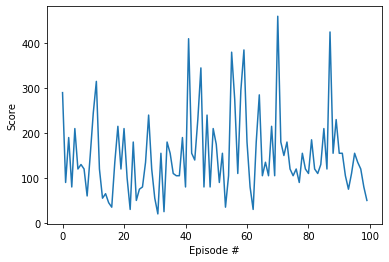

In [13]:
scores = train(100)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 12: Watch a Smart Agent!

In [16]:
score = 0
state = stack_frame(None, env.reset(), True)
while True:
    env.render()
    action, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frame(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

You Final score is: 205.0
